In [1]:
standard = {
    "没有(根本不)": 1,
    "不会": 1,
    "很少(有一点)": 2,
    "偶尔": 2,
    "有时(有些)": 3,
    "还可以": 3,
    "经常(相当)": 4,
    "总是(非常)": 5
}

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]
    score: int

graph_builder = StateGraph(State)

In [2]:
from langchain.tools import Tool
from langchain_community.llms.moonshot import Moonshot
import numpy as np
import matplotlib.pyplot as plt
import time
from cmllm import TypeClassifier, Valuator, SoulutionProposer
from cmllm import Score
import os


score = Score()
score_tools = [
    Tool.from_function(
        func=score.calculate_final,
        name="Calculate conversion scores",
        description="useful for when you need to calculate conversion scores from raw score"
        # coroutine= ... <- you can specify an async method if desired as well
    ),
    Tool.from_function(
        func=score.update,
        name="Update score after questions",
        description="useful for when you need to record score of answer"
        # coroutine= ... <- you can specify an async method if desired as well
    )
    ]
os.environ["MOONSHOT_API_KEY"] = "sk-jp2VoAvlcR3QS8azmXmFIRqxLA4nEVF4o48j8EkJilkm3DfV"
llm = Moonshot(temperature=0.1)
que = '您胃脘部背部或腰膝部怕冷吗？'
va = Valuator(llm, standard, score_tools)
ad = SoulutionProposer(llm)
# va.invoke({'question':que, 'answer':'有时会感到怕冷，特别是在吃完冰淇淋后，但冬天经常容易'})

In [4]:
ans_list = []
with open('ans.txt', 'r', encoding='utf-8') as file:
    for line in file:
        ans = line.strip()  # 去掉行末尾的空白字符
        if ans:
            ans_list.append(ans)

In [5]:
ans_iterator = iter(ans_list)

In [6]:
# 定义文件夹路径
folder_path = './questions'
result = {}
final = {}
# 遍历文件夹中的所有文件
for filename in os.listdir(folder_path):
    # 构建每个文件的完整路径
    file_path = os.path.join(folder_path, filename)
    catagory = os.path.splitext(filename)[0]
    # 检查是否为文件
    if os.path.isfile(file_path):
        print(f"Processing file: {filename}")
        
        # 打开并逐行读取文件中的问题
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                question = line.strip()  # 去掉行末尾的空白字符
                if question:
                    print(f"Question: {question}", flush=True)
                    ans = next(ans_iterator)
                    # ans = input()
                    print(f"Answer:{ans}", flush=True)
                    va.invoke({'question':que, 'answer': ans})
    result[catagory] = score.score
    final[catagory] = score.calculate_final()


Processing file: 平和体质.txt
Question: 您精力充沛吗？
Answer:还可以，白天时候精力很充沛
3
Question: 您容易疲乏吗？*
Answer:有时候会感到累


KeyboardInterrupt: 

In [7]:
print(result)
print(final)

{}
{}


In [8]:
def final_show(final):
    plt.rcParams['font.sans-serif'] = ["SimHei"]  # 用黑体显示中文
    plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号
    # 获取标签和数值
    labels = list(final.keys())
    values = list(final.values())
    num_vars = len(labels)

    # 计算角度
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # 闭合图形
    values += values[:1]
    angles += angles[:1]

    # 初始化雷达图
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # 绘制雷达图
    ax.fill(angles, values, color='skyblue', alpha=0.4)
    ax.plot(angles, values, color='blue', linewidth=2)

    # 添加标签
    ax.set_ylim(0, 70) 
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=14)
    ax.tick_params(pad=20)

    # 显示图形
    plt.show()

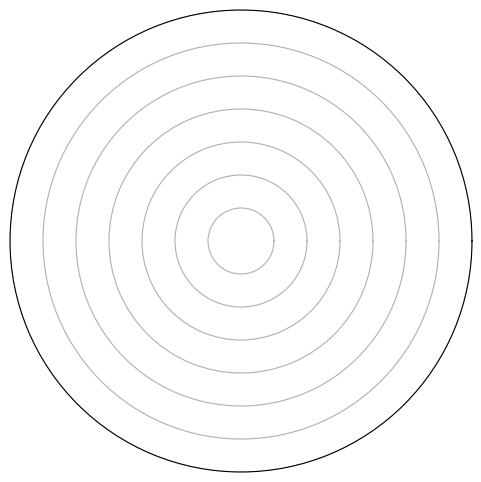

In [9]:
final_show(final)

In [3]:
result = {'平和体质': 23, '阴虚体质': 14, '痰湿体质': 20, '气虚体质': 17, '特禀体质': 16, '阳虚体质': 16, '湿热体质': 19, '淤血体质': 8, '气郁体质': 10}
final = {'平和体质': 46.875, '阴虚体质': 18.75, '痰湿体质': 37.5, '气虚体质': 28.125, '特禀体质': 32.142857142857146, '阳虚体质': 32.142857142857146, '湿热体质': 42.857142857142854, '淤血体质': 3.571428571428571, '气郁体质': 10.714285714285714}

In [9]:
from cmllm import type_judge
type_result = type_judge(final)
type_result['淤血体质'] = 2

In [10]:
print(type_result)

{'平和体质': 0, '阴虚体质': 0, '痰湿体质': 1, '气虚体质': 0, '特禀体质': 1, '阳虚体质': 1, '湿热体质': 2, '淤血体质': 2, '气郁体质': 0}


In [11]:
final_type = [key for key, value in type_result.items() if value == 2]
print(final_type)

['湿热体质', '淤血体质']


In [12]:
tend_type = [key for key, value in type_result.items() if value == 1]
print(tend_type)

['痰湿体质', '特禀体质', '阳虚体质']


In [ ]:
text_result = ad.invoke({"result": final_type, "pretend_result": tend_type})
print(text_result) 